# **Loan Default Prediction**

![Loan image](https://cdn.pixabay.com/photo/2020/02/18/08/35/finance-4858797_960_720.jpg)

## **Objectives**

- Explorate and clean the SBA Loan Dataset

- Built & Train an Ml model to predict whether a loan backed by the Small Business Administration (SBA) government agency will pay off in full or default.

- Deploy the model a webapp

Author: Luis Fernando Salazar Salinas Date: 18/05/2022

### **Loan Default Dataset**

The original data set is from the U.S.SBA loan database, which includes historical data from 1987 through 2014 (899,164 observations) with 27 variables. The data set includes information on whether the loan was paid off in full or if the SBA had to charge off any amount and how much that amount was. 

According to Li, Mickel, & Taylor 2018, the project filtered the  original dataset to California State and  add the following new variables:

- New
- Portion 
- RealEstate
- Recession
- Default(Target)


For more information on this data set, visit the follow url: https://amstat.tandfonline.com/doi/full/10.1080/10691898.2018.1434342

In [ ]:
## importing the libraries
import os 
import warnings
warnings.simplefilter(action ="ignore")
#import wget
import pickle

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import numpy as np
import pandas as pd

from pandas_profiling import ProfileReport
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay


from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
## Conect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def wangle(input_path):
    
    ## Conver to Dataframe
    df = pd.read_csv(input_path)
    
    ## Mask to State 'California' (Spatial limit)
    mask_ca = df['State'] == 'CA'
    
    ## Apply mask
    df = df[mask_ca]
    
    ## Remove symbols 
    list_s = ['DisbursementGross','BalanceGross','ChgOffPrinGr', 'GrAppv','SBA_Appv']

    for colm in list_s:
        df[colm] = df[colm].str.replace('[$,]', '').astype(float)
    
        
    ## List of unnecessary, inconsistent and leaky variables
    list_un = ['LoanNr_ChkDgt','Name','State', 'Zip','Bank',
               'BankState','NAICS','ApprovalDate','NewExist',
               'ApprovalFY', 'FranchiseCode','ChgOffPrinGr','ChgOffDate',
               'BalanceGross','RevLineCr','LowDoc','NoEmp','CreateJob','RetainedJob'
        
    ]
     
    ## Maintain the 10 cities with the most information and classify the other cities as others
    ten_cities = df['City'].value_counts().head(10).index
    df['City'] = df['City'].apply(lambda c : c if c in ten_cities else 'Others')
    
    ## Setting the DisbursementDate
    df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate']).astype(str)
    df['DisbursementDate'] = df['DisbursementDate'].str.split('-', expand = True)[0]
    
    ## Create Recession variable
    list_rece = []
    
    for rece in df['DisbursementDate']:
        if rece >= '2007' and rece <= '2009':
            rece = 'Active'
        else:
            rece = 'Not_Active'
 
        list_rece.append(rece)
    
    df['Recession'] = list_rece
    
    list_un.append('DisbursementDate')
    
    
    # Create a Real State variable 
    list_real = []
    
    for real in df['Term']:
        if real >=240:
            real = 1
        else:
            real = 0
        
        list_real.append(real)
        
    df['RealState'] = list_real
    

    # SBA's Guaranteed Portion of Approved Loan
    df['portion'] = df['SBA_Appv']/ df['GrAppv']
    
    
    # New target variable
    # PIF(successfully paid in full): 0
    # CHGOFF(default): 1
    class_mapping = {
        'P I F':0,
        'CHGOFF':1
    }
    
    df['Default'] = df['MIS_Status'].map(class_mapping)
    
    # Drop columns
    df.drop(columns = list_un, inplace = True)
     
    return df

In [ ]:
df = wangle('/.../SBAnational.csv').reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130619 entries, 0 to 130618
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   City                 130619 non-null  object 
 1   NAICS_2DIG           101918 non-null  float64
 2   Industry_definition  101918 non-null  object 
 3   Term                 130619 non-null  int64  
 4   New                  130496 non-null  float64
 5   UrbanRural           130619 non-null  int64  
 6   DisbursementGross    130619 non-null  float64
 7   MIS_Status           130488 non-null  object 
 8   GrAppv               130619 non-null  float64
 9   SBA_Appv             130619 non-null  float64
 10  Recession            130619 non-null  object 
 11  RealState            130619 non-null  int64  
 12  portion              130619 non-null  float64
 13  Default              130488 non-null  float64
dtypes: float64(7), int64(3), object(4)
memory usage: 14.0+ MB


In [ ]:
df.head(10)

City  NAICS_2DIG                               Industry_definition  \
0       Others        61.0                              Educational Services   
1       Others         NaN                                               NaN   
2       Others         NaN                                               NaN   
3  LOS ANGELES        31.0                                     Manufacturing   
4    SANTA ANA         NaN                                               NaN   
5       Others        54.0  Professional, Scientific, and Technical Services   
6       Others        81.0                                    Other Services   
7       Others         NaN                                               NaN   
8       Others        42.0                                   Wholesale Trade   
9       Others        51.0                                       Information   

   Term  New  UrbanRural  DisbursementGross MIS_Status    GrAppv  SBA_Appv  \
0    83  1.0           1           438541.0      P I F  100000.0   50000.0   
1    84  0.0           0            30570.0      P I F   25000.0   12500.0   
2    84  0.0           0            15000.0      P I F   15000.0    7500.0   
3    36  1.0           1            35000.0      P I F   35000.0   17500.0   
4   300  0.0           0           745000.0      P I F  745000.0  558750.0   
5    84  0.0           0            18107.0      P I F   20000.0   10000.0   
6    84  0.0           0            10000.0      P I F   10000.0    5000.0   
7    60  0.0           0            40000.0      P I F   40000.0   32000.0   
8    36  0.0           1           577000.0      P I F  300000.0  150000.0   
9    84  1.0           1             5000.0      P I F    5000.0    4250.0   

    Recession  RealState  portion  Default  
0  Not_Active          0     0.50      0.0  
1  Not_Active          0     0.50      0.0  
2  Not_Active          0     0.50      0.0  
3  Not_Active          0     0.50      0.0  
4  Not_Active          1     0.75      0.0  
5  Not_Active          0     0.50      0.0  
6  Not_Active          0     0.50      0.0  
7  Not_Active          0     0.80      0.0  
8  Not_Active          0     0.50      0.0  
9  Not_Active          0     0.85      0.0

In [ ]:
print(f"Data dimensionality {df.shape}")

Data dimensionality (130619, 14)


### **Exploratory Data Analysis**

- Report:
   - Missing values 
   - Outliers
   - Duplicates observation
   - Distributions 
   - Correlactions
   - Interactions

- Visial analysis
  - Loan Status during Recessesion
  - Loan Status by Gross Disbursement
  - Loan Status by the SBA’s Guaranteed Amount of Approved
  - Probability of loan default by industry

#### **Pandas profile report** 

In [ ]:
## Pandas profile Report
report = ProfileReport(df,
                       title = 'National SBA data',
                       dataset ={
                           'description': "This profile report was generated by Luis F. Salazar Salinas",
                           'copyright_holder': "Luis Salazar",
                           'copyright_year': "2022",
                           'url':"https://github.com/Luissalazarsalinas"
                       },
                       variables = {
                           'descriptions':{
                               'City': 'Barrower City(only to California State)',
                               'NAICS_2DIG': 'North American Industry Classification System code',
                               'Industry_definition':' Industry Definition from North American Industry Classification System code',
                               'Term':'Loan term in months',
                               'New':'0 = Existing Business, 1 = New Business',
                               'UrbanRural': '1= Urban, 2= Rural, 0 = Undefined',
                               'DisbursementGross': 'Amount Disbursed',
                               'MIS_Status': 'Loan Status',
                               'GrAppv':'Gross Amount of Loan Approved by Bank',
                               'SBA_Appv': 'SBA’s Guaranteed Amount of Approved Loan',
                               'Recession': '1= if loan is active during Great Recession, 0= otherwise',
                               'RealState': '1= if loan is backed by real estate, 0= otherwise',
                               'portion	': 'Proportion of Gross Amount Guaranteed by SBA',
                               'Default': '1= if MIS_Status=CHGOFF, 0= if MIS_Status=P I F',

                           }
                       },
                       html = {'style':{'full_width':False}})

In [ ]:
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Save report 
report.to_file('Loan_default_report.html')
report.to_file('Loan_default_report.json')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### **Basic visual analysis**

In [ ]:
### Ressecion analysis 
default_reces = pd.DataFrame(df.groupby('Recession')['Default'].mean())
## Proportions of loan paid in full during recession
default_reces['Loan Paid in Full'] = (
    df[(df['MIS_Status'] == 'P I F') ].groupby('Recession')['Default'].count()/
    df.groupby('Recession')['Default'].count()
)
## Proportions of loan default during recession
default_reces['Loan Default'] = (
    df[(df['MIS_Status'] == 'CHGOFF') ].groupby('Recession')['Default'].count()/
    df.groupby('Recession')['Default'].count()
)
default_reces.drop(columns = 'Default', inplace = True)

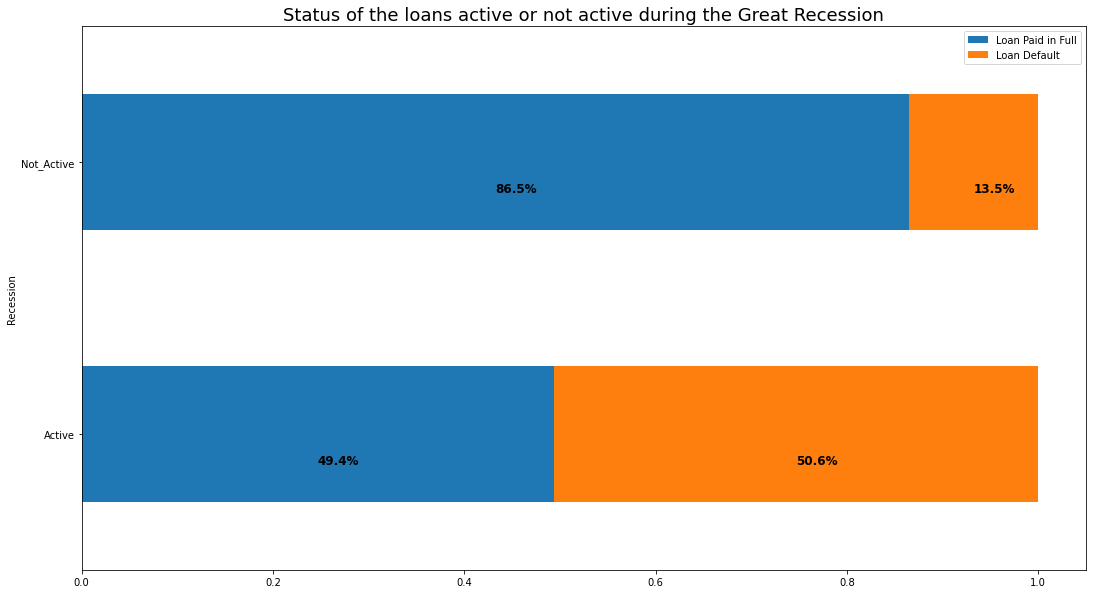

In [ ]:
default_reces.plot(kind = 'barh', stacked = True, figsize = (18,10))
plt.title('Status of the loans active or not active during the Great Recession', fontsize = 18)
plt.legend(loc = 'upper right')

for n, x in enumerate([*default_reces.index.values]):
    for (proportion, y_loc) in zip(default_reces.loc[x],
                                   default_reces.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.show()

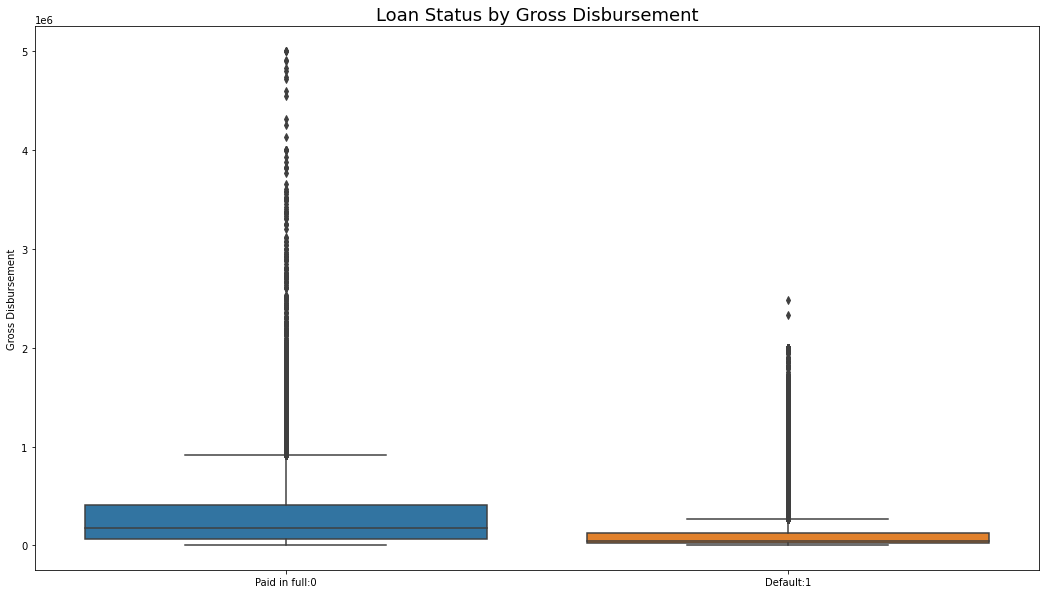

In [ ]:
fig, ax = plt.subplots(figsize =(18,10))
sns.boxplot(data = df, x='Default', y='DisbursementGross', ax = ax)
ax.set_xlabel('')
ax.set_ylabel('Gross Disbursement')
ax.set_title('Loan Status by Gross Disbursement', fontsize = 18)
ax.xaxis.set_ticklabels(["Paid in full:0", "Default:1"]);

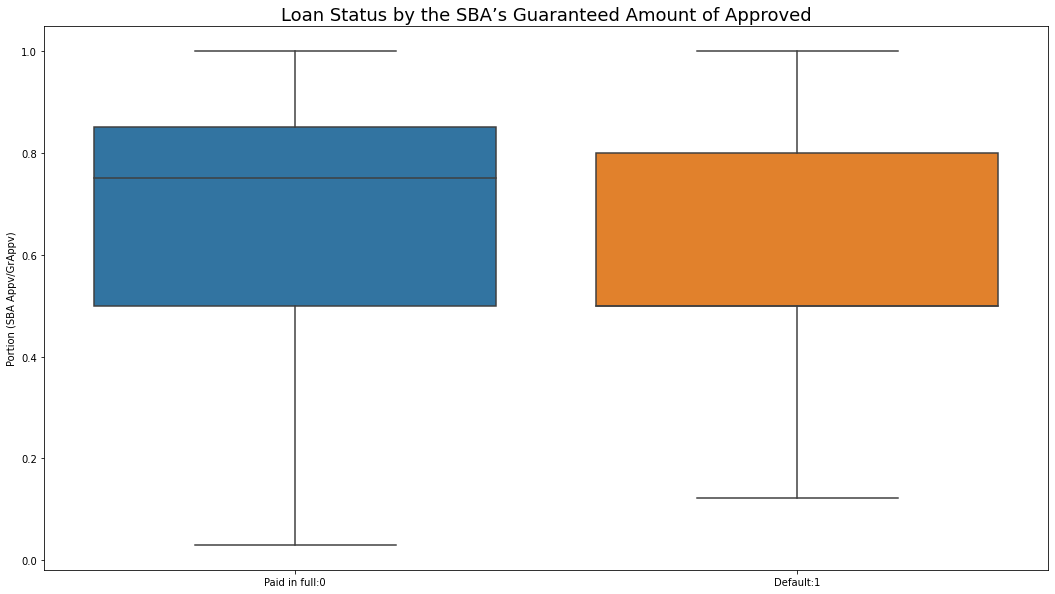

In [ ]:
fig, ax = plt.subplots(figsize =(18,10))
sns.boxplot(data = df, x='Default', y='portion', ax = ax)
ax.set_xlabel('')
ax.set_ylabel('Portion (SBA Appv/GrAppv)')
ax.xaxis.set_ticklabels(["Paid in full:0", "Default:1"])
ax.set_title('Loan Status by the SBA’s Guaranteed Amount of Approved',fontsize = 18);

In [ ]:
## Pivot table
industry_pivot = pd.pivot_table(df, index = 'Industry_definition', values = 'Default', aggfunc = np.mean)

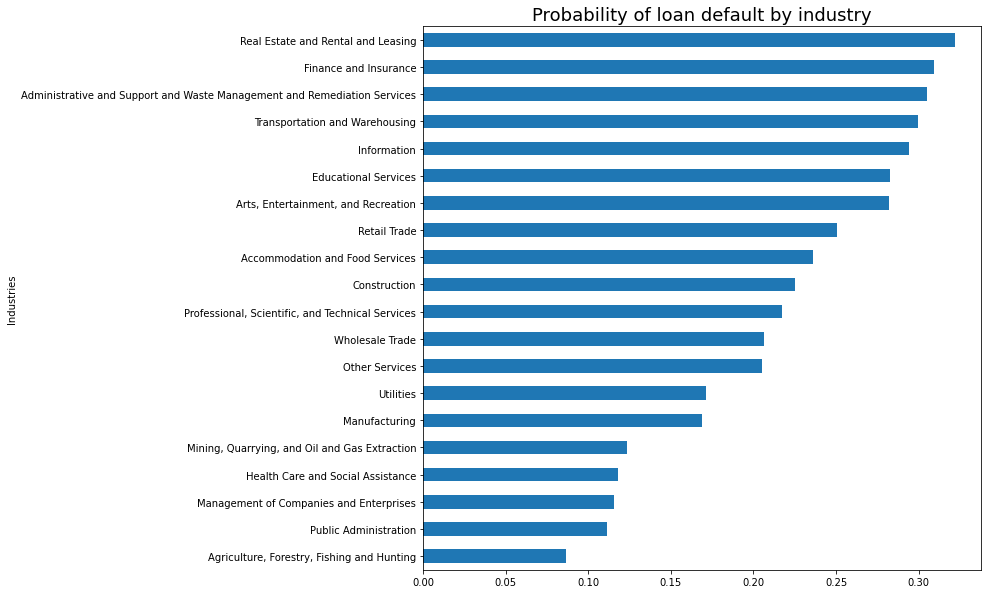

In [ ]:
industry_pivot.sort_values(by ='Default', ascending=True).plot(
    kind='barh', 
    legend = False,
    figsize = (10,10),
    #title = 'Probability of loan default by industry'
)
plt.ylabel('Industries')
plt.title('Probability of loan default by industry', fontsize = 18);

### **Data Cleaning** 

In [ ]:
def clean(df):
    
    # Drop Unnecessary variable to modeling 
    list_drp = ['MIS_Status', 'Industry_definition'] 
    df.drop(columns = list_drp, inplace = True)
    
    # Drop missing values
    df.dropna(inplace =True)
    
    # Drop duplicate values
    df.drop_duplicates(inplace=True)
    
    # Reset index
    df.reset_index(drop = True, inplace = True)
    
    # 
    list_ = ['NAICS_2DIG','New','Default']
    
    for colm in list_:
        
        df[colm] = df[colm].astype(int)
    
    return df

In [ ]:
df = clean(df)
print(df.shape)
df.head(10)

(87032, 12)


City  NAICS_2DIG  Term  New  UrbanRural  DisbursementGross  \
0       Others          61    83    1           1           438541.0   
1  LOS ANGELES          31    36    1           1            35000.0   
2       Others          54    84    0           0            18107.0   
3       Others          81    84    0           0            10000.0   
4       Others          42    36    0           1           577000.0   
5       Others          51    84    1           1             5000.0   
6       Others          44    84    0           0             7085.0   
7       Others          72    84    0           1           122977.0   
8       Others          81    84    1           0            95000.0   
9       Others          44   120    0           0            50000.0   

     GrAppv  SBA_Appv   Recession  RealState  portion  Default  
0  100000.0   50000.0  Not_Active          0     0.50        0  
1   35000.0   17500.0  Not_Active          0     0.50        0  
2   20000.0   10000.0  Not_Active          0     0.50        0  
3   10000.0    5000.0  Not_Active          0     0.50        0  
4  300000.0  150000.0  Not_Active          0     0.50        0  
5    5000.0    4250.0  Not_Active          0     0.85        0  
6   25000.0   12500.0  Not_Active          0     0.50        0  
7   50000.0   25000.0  Not_Active          0     0.50        0  
8   95000.0   76000.0  Not_Active          0     0.80        0  
9   50000.0   37500.0  Not_Active          0     0.75        0

In [ ]:
## Save clean dataset
df.to_csv('SBAnational_clean.csv', index= False)

### **Data Preprocessing**


In [ ]:
def data_prepro(df):
    
    # Split data into Features and target 
    target = 'Default'
    X = df.drop(columns = target)
    y = df[target]
    
    # Transform Recession variable 
    bi_rece = []
    for rece in X['Recession']:
      if rece == 'Active':
        rece = 1
      else:
        rece = 0
      bi_rece.append(rece)
    
    X['Recession'] = bi_rece
    # categorical variable
    enco = OneHotEncoder(cols='City', return_df=True, use_cat_names=True)
    X = enco.fit_transform(X)
    
    ## Scaler the data
    st = StandardScaler()
    X = pd.DataFrame(st.fit_transform(X), columns = X.columns)
    
    return X, y

In [ ]:
X_tran, y = data_prepro(df)
print(f"Features shape: {X_tran.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (87032, 21)
Labels shape: (87032,)


In [ ]:
## split data using StratifiedShuffleSplit to unbalance data

strat_shuf_split = StratifiedShuffleSplit(n_splits = 1,
                                          test_size = 0.2,
                                          random_state= 42)

train_idx, test_idx = next(strat_shuf_split.split(X_tran, y))

## Create the dataframe
X_train = X_tran.loc[train_idx]
y_train = y.loc[train_idx]

X_test  = X_tran.loc[test_idx]
y_test  = y.loc[test_idx]

In [ ]:
strat_shuf_split_2 = StratifiedShuffleSplit(n_splits = 1,
                                          test_size = 0.25,
                                          random_state= 42)
                                          
train_idx, val_idx = next(strat_shuf_split_2.split(X_train, y_train))

## Create the dataframe
X_train = X_tran.loc[train_idx]
y_train = y.loc[train_idx]

X_val  = X_tran.loc[val_idx]
y_val  = y.loc[val_idx]

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_validation shape: {X_val.shape}")
print(f"y_validation shape: {y_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (52218, 21)
y_train shape: (52218,)
X_validation shape: (17407, 21)
y_validation shape: (17407,)
X_test shape:(17407, 21)
y_test shape: (17407,)


In [ ]:
# OverSampling (SMOTE) method to unbalance data
from imblearn.over_sampling import SMOTE
smote_over = SMOTE(random_state = 42)
X_train_over, y_train_over = smote_over.fit_resample(X_train, y_train)
#
print(f"X train over shape: {X_train_over.shape}")
print(f"y train over shape: {y_train_over.shape}")

X train over shape: (76452, 21)
y train over shape: (76452,)


In [ ]:
# Class proportions 
y_train_over.value_counts(normalize =True)

0    0.5
1    0.5
Name: Default, dtype: float64

### **Modelling**
-  Models:
   - RandomForestClassifier
   - XGBClassifier

- Models Performances:
   - Classification Report:
      - Accuracy
      - Presicion
      - Recall
      - F1-Score
      - AUC

- Feature selection (based in the best model):
  - The 10 best features from feature importance plot

- Hyperparameters Tuning (the best model):
  - Bayes Optimizer (Hyperotp)

- Final Model:
  - Predictions(inference) with the test set

  - Metrics:
     - Confusion Matrix
     - Roc-Auc curve

  


#### **RandomForest Model**

In [ ]:
## RandomForest 
model_rf = RandomForestClassifier(
    n_estimators = 1000,
    max_depth = 5,
    class_weight = 'balanced',
    random_state = 100,
    n_jobs = -1
)

model_rf.fit(X_train_over, y_train_over)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000,
                       n_jobs=-1, random_state=100)

In [ ]:
## model performance 
acc_train_rf = model_rf.score(X_train_over, y_train_over)
acc_val_rf = model_rf.score(X_val, y_val)

print(f"RandomForest Train Accuracy:{round(acc_train_rf,2)} \nRandomForest Validation Accuracy: {round(acc_val_rf,2)}")

RandomForest Train Accuracy:0.91 
RandomForest Validation Accuracy: 0.89


In [ ]:
## RandomForest Classification report with the validation set
y_pred_rf = model_rf.predict(X_val)
cr_rf = classification_report(y_val, y_pred_rf)
print(cr_rf)

score_cr_rf = pd.DataFrame(
    {
        'accuracy': accuracy_score(y_val, y_pred_rf),
        'precision': precision_score(y_val, y_pred_rf),
        'recall': recall_score(y_val, y_pred_rf),
        'f1': f1_score(y_val, y_pred_rf),
        'auc': roc_auc_score(y_val, y_pred_rf),
    },
    index = pd.Index([0])
)
print(score_cr_rf)

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     12667
           1       0.74      0.92      0.82      4740

    accuracy                           0.89     17407
   macro avg       0.85      0.90      0.87     17407
weighted avg       0.91      0.89      0.89     17407

   accuracy  precision    recall        f1       auc
0  0.891021   0.742701  0.917722  0.820987  0.899375


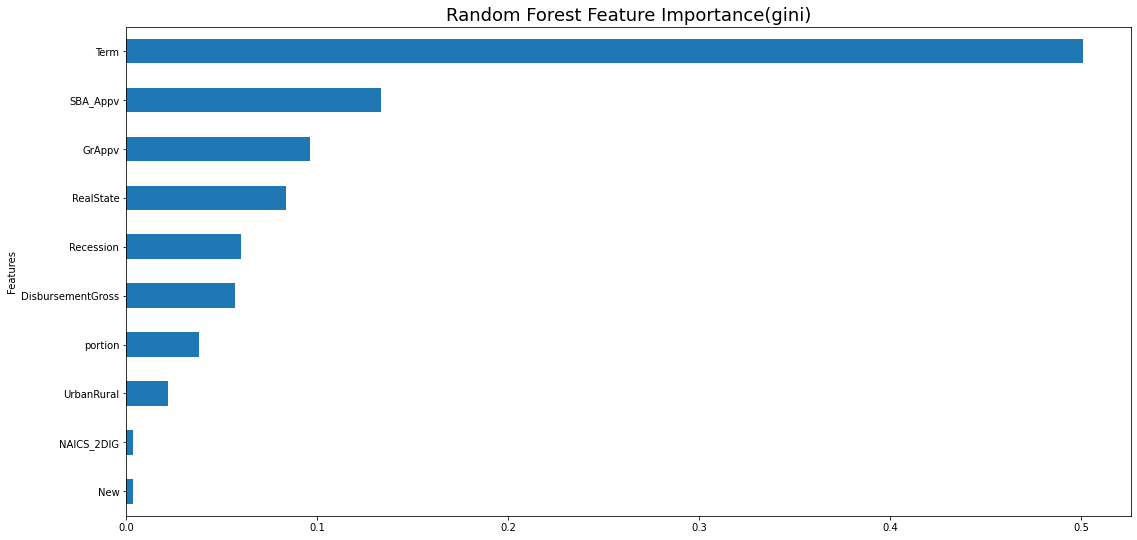

In [ ]:
## RandomForest Feature importance
fea_imp_rf = pd.Series(model_rf.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_rf.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance(gini)', fontsize = 18);

#### **XGB Model**

In [ ]:
## Scale pos weight definition
scale_pos_weight = len(df[df['Default'] == 0]) / len(df[df['Default'] == 1])

In [ ]:
## XGBClassifier

model_xgb = xgb.XGBClassifier(silent = False,
                          objective = 'binary:logistic',
                          tree_method = 'gpu_hist',
                          scale_pos_weight = scale_pos_weight,
                          subsample = 0.8,
                          colsample_bytree = 0.8,
                          max_depth = 5,
                          learning_rate = 0.01,
                          n_estimators = 1000,
                          seed = 100
                          )

model_xgb.fit(X_train_over, y_train_over)

XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=5,
              n_estimators=1000, scale_pos_weight=2.9787876017189356, seed=100,
              silent=False, subsample=0.8, tree_method='gpu_hist')

In [ ]:
## Model performance with the train a validation set
acc_train_xgb = model_xgb.score(X_train_over, y_train_over)
acc_val_xgb = model_xgb.score(X_val, y_val)

print(f"XGB Train Accuracy:{round(acc_train_xgb,2)} \nXGB Validation Accuracy: {round(acc_val_xgb,2)}")

XGB Train Accuracy:0.94 
XGB Validation Accuracy: 0.92


In [ ]:
## Xgb Classification report with the validation set
y_pred_xgb = model_xgb.predict(X_val)
cr_xgb = classification_report(y_val, y_pred_xgb)
print(cr_xgb)

score_cr_xgb = pd.DataFrame(
    {
        'accuracy': accuracy_score(y_val, y_pred_xgb),
        'precision': precision_score(y_val, y_pred_xgb),
        'recall': recall_score(y_val, y_pred_xgb),
        'f1': f1_score(y_val, y_pred_xgb),
        'auc': roc_auc_score(y_val, y_pred_xgb),
    },
    index = pd.Index([0])
)
print(score_cr_xgb)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     12667
           1       0.79      0.97      0.87      4740

    accuracy                           0.92     17407
   macro avg       0.89      0.94      0.91     17407
weighted avg       0.93      0.92      0.92     17407

   accuracy  precision    recall        f1       auc
0  0.921985   0.791451  0.968776  0.871182  0.936626


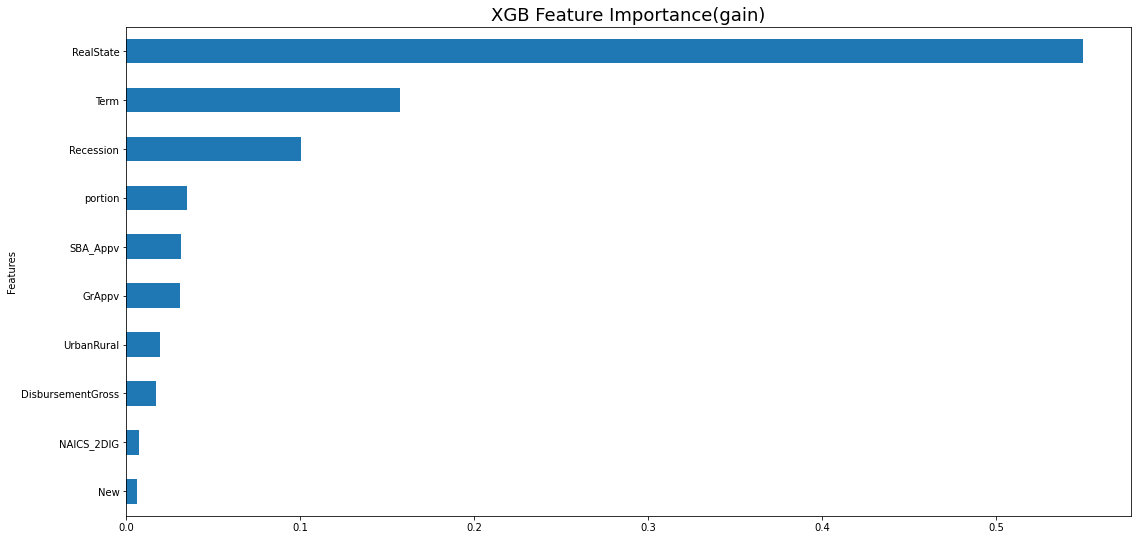

In [ ]:
## Feature importance
fea_imp_xgb = pd.Series(model_xgb.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_xgb.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Feature Importance(gain)', fontsize = 18);

#### **Feature selection (Xgb importance)**

In [ ]:
# We Going to select the best features according to xgb model
drop = list(fea_imp_xgb.head(11).index)
X_train_over_s = X_train_over.drop(columns = drop)
X_test_s = X_test.drop(columns = drop)

#### **Hyperparameters Tuning (XGB Model)**

In [ ]:
## Hyperparameters tuning with Bayes-optimizer 
###choose hyperparameters
## Bayes Optimizer
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {
         'tree_method': hp.choice('tree_method',['gpu_hist']),
         'subsample': hp.uniform('subsample', 0.5, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
         'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
         'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'max_depth': hp.quniform('max_depth', 6, 12, 1),
         'gamma': hp.quniform('gamma', 1, 9, 1),
         'reg_alpha': hp.uniform('reg_alpha', 0.4, 1.0),
         'n_estimators': hp.quniform('n_estimators', 300, 3000, 1), 
         'seed' : 100 
    }

def objective(space):

  model = xgb.XGBClassifier(
                        tree_method = space['tree_method'],
                        subsample = space['subsample'],
                        colsample_bytree = space['colsample_bytree'],
                        colsample_bylevel = space['colsample_bylevel'],
                        learning_rate = space['learning_rate'],
                        min_child_weight = int(space['min_child_weight']),
                        max_depth = int(space['max_depth']),
                        gamma = int(space['gamma']),
                        reg_alpha = space['reg_alpha'],
                        n_estimators = int(space['n_estimators']),
                        seed = int(space['seed']),
                                 )
  accuracy = cross_val_score(model, X_train_over_s, y_train_over, cv = 4).mean()
 
  return {'loss': -accuracy, 'status': STATUS_OK }

    
trials = Trials()

best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 60,
            trials= trials)
best

100%|██████████| 60/60 [3:29:22<00:00, 209.38s/it, best loss: -0.9576858682572071]


{'colsample_bylevel': 0.6449546062893828,
 'colsample_bytree': 0.7264528946822975,
 'gamma': 6.0,
 'learning_rate': 0.01939990039335998,
 'max_depth': 12.0,
 'min_child_weight': 1.0,
 'n_estimators': 1561.0,
 'reg_alpha': 0.9033302585377474,
 'subsample': 0.6545917767374533,
 'tree_method': 0}

#### **Final Model**

In [ ]:
final_model = xgb.XGBClassifier(
    
    objective = 'binary:logistic',
    tree_method = 'gpu_hist',
    learning_rate = best['learning_rate'],
    max_depth = int(best['max_depth']),
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    colsample_bylevel = best['colsample_bylevel'],
    min_child_weight = int(best['min_child_weight']),
    reg_alpha = best['reg_alpha'],
    gamma = int(best['gamma']),
    n_estimators = int(best['n_estimators']),

)

final_model.fit(X_train_over_s, y_train_over)

XGBClassifier(colsample_bylevel=0.6449546062893828,
              colsample_bytree=0.7264528946822975, gamma=6,
              learning_rate=0.01939990039335998, max_depth=12,
              n_estimators=1561, reg_alpha=0.9033302585377474,
              subsample=0.6545917767374533, tree_method='gpu_hist')

##### **Evaluate the Final Model with the test set**

##### Predictions

In [ ]:
y_pred = final_model.predict(X_test_s)
y_pred_pro = final_model.predict_proba(X_test_s)

##### Model Performance
- Metrics:
 - Acuraccy
 - Roc-Auc curve
 - Confusion Matrix

Accuracy: 0.9612224966967312 
Roc_Auc score: 0.9543633692887837


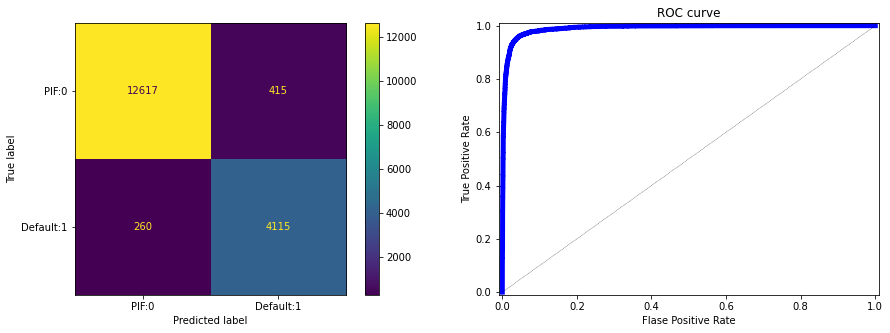

In [ ]:
## Accuracy and roc_auc score
print(f"Accuracy: {accuracy_score(y_test, y_pred)} \nRoc_Auc score: {roc_auc_score(y_test, y_pred)}")

## Roc curve
fpr, tpr, thr = roc_curve(y_test, y_pred_pro[:,1])

## plot
plt.figure(figsize =(15,5))
layout = (1,2)

cmd = plt.subplot2grid(layout,(0,0))
rc = plt.subplot2grid(layout,(0,1))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = cmd)
cmd.xaxis.set_ticklabels(["PIF:0", "Default:1"])
cmd.yaxis.set_ticklabels(["PIF:0", "Default:1"])

rc.plot(fpr, tpr, color ='blue', linewidth = 5)
rc.plot([0, 1],[0, 1], ls = '--', color = 'black', lw = .3)
rc.set(xlabel = 'False Positive Rate',
       ylabel = 'True Positive Rate',
       xlim =[-.01, 1.01], ylim =[-.01, 1.01],
       title = 'ROC curve')

plt.show()

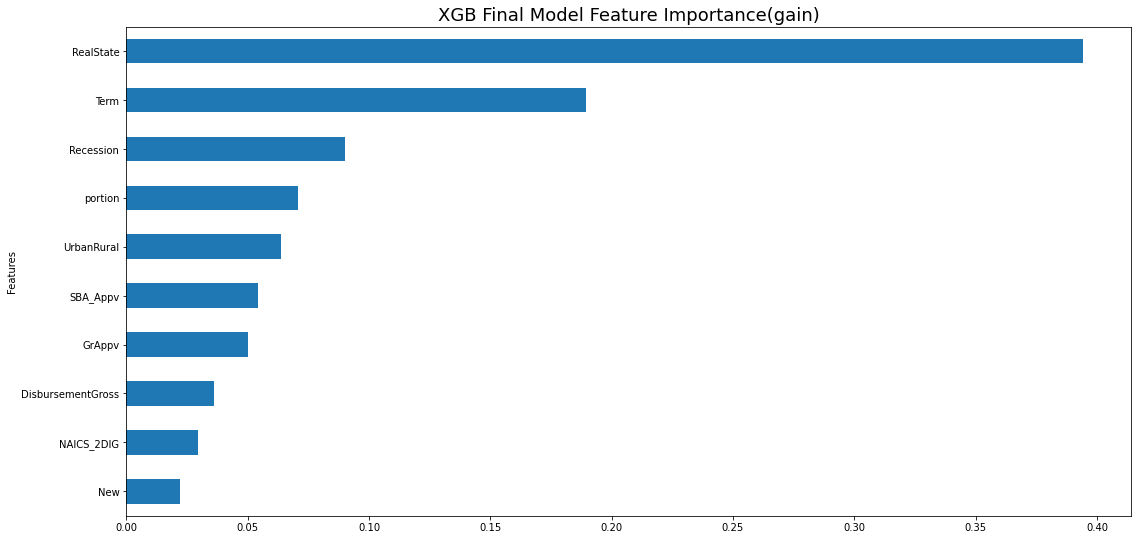

In [ ]:
## Feature importance
fea_imp_xgb_h = pd.Series(final_model.feature_importances_, index = X_train_over_s.columns)

# plot of the 10 best predictors 
fea_imp_xgb_h.sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Final Model Feature Importance(gain)', fontsize = 18);

##### **Serialization**

In [ ]:
with open('LD_xgb_Model_v1.pkl', 'wb') as f:
  pickle.dump(final_model, f)